In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Veri setinin okutulması
df = pd.read_csv(r"C:\Users\umut3\PycharmProjects\ml5\train.csv")

In [2]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df)

##################### Shape #####################
(1460, 81)
##################### Types #####################
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2  

In [3]:
# Aykırı değerlerin veriden uzaklaştırılması
df = df.loc[df["SalePrice"]<=400000,]

check_df(df)

##################### Shape #####################
(1432, 81)
##################### Types #####################
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2  

In [4]:
##################################
# NUMERİK VE KATEGORİK DEĞİŞKENLERİN YAKALANMASI
##################################

def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, cat_but_car, num_cols, num_but_cat

cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)


Observations: 1432
Variables: 81
cat_cols: 53
num_cols: 27
cat_but_car: 1
num_but_cat: 11


In [5]:
######################################
# 2. Kategorik Değişken Analizi (Analysis of Categorical Variables)
######################################

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col)

         MSZoning  Ratio
RL           1124 78.492
RM            217 15.154
FV             65  4.539
RH             16  1.117
C (all)        10  0.698
      Street  Ratio
Pave    1426 99.581
Grvl       6  0.419
      Alley  Ratio
Grvl     50  3.492
Pave     41  2.863
     LotShape  Ratio
Reg       916 63.966
IR1       471 32.891
IR2        35  2.444
IR3        10  0.698
     LandContour  Ratio
Lvl         1285 89.735
Bnk           63  4.399
HLS           48  3.352
Low           36  2.514
        Utilities  Ratio
AllPub       1431 99.930
NoSeWa          1  0.070
         LotConfig  Ratio
Inside        1034 72.207
Corner         260 18.156
CulDSac         87  6.075
FR2             47  3.282
FR3              4  0.279
     LandSlope  Ratio
Gtl       1355 94.623
Mod         64  4.469
Sev         13  0.908
        Condition1  Ratio
Norm          1234 86.173
Feedr           81  5.656
Artery          47  3.282
RRAn            25  1.746
PosN            19  1.327
RRAe            11  0.768
PosA   

count   1432.000
mean     731.731
std      422.265
min        1.000
5%        73.550
10%      145.100
20%      293.200
30%      438.300
40%      586.400
50%      733.500
60%      879.600
70%     1023.700
80%     1168.800
90%     1314.900
95%     1388.450
99%     1445.690
max     1460.000
Name: Id, dtype: float64


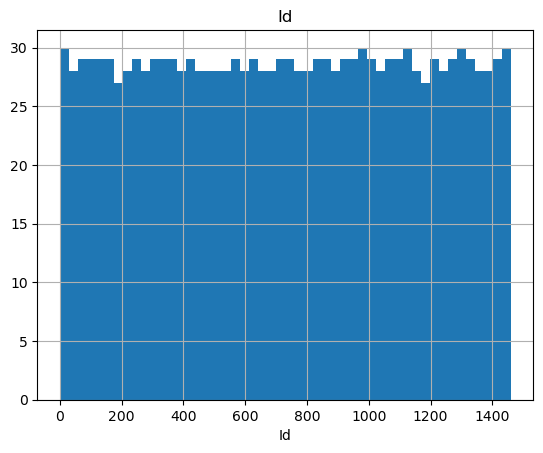

#####################################
count   1432.000
mean      57.112
std       42.596
min       20.000
5%        20.000
10%       20.000
20%       20.000
30%       20.000
40%       30.000
50%       50.000
60%       60.000
70%       60.000
80%       80.000
90%      120.000
95%      160.000
99%      190.000
max      190.000
Name: MSSubClass, dtype: float64


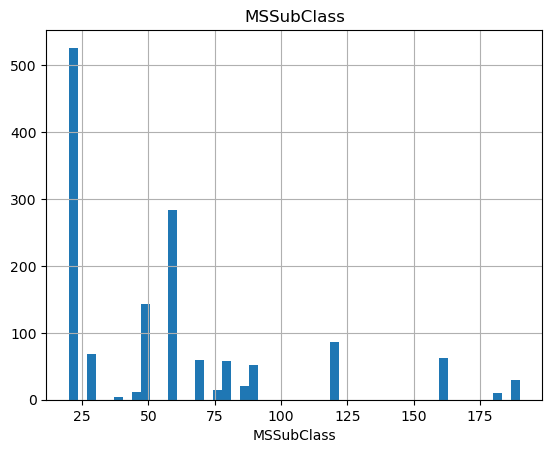

#####################################
count   1175.000
mean      69.557
std       23.891
min       21.000
5%        34.000
10%       43.000
20%       53.000
30%       60.000
40%       63.000
50%       69.000
60%       73.000
70%       78.800
80%       84.200
90%       94.000
95%      105.000
99%      138.520
max      313.000
Name: LotFrontage, dtype: float64


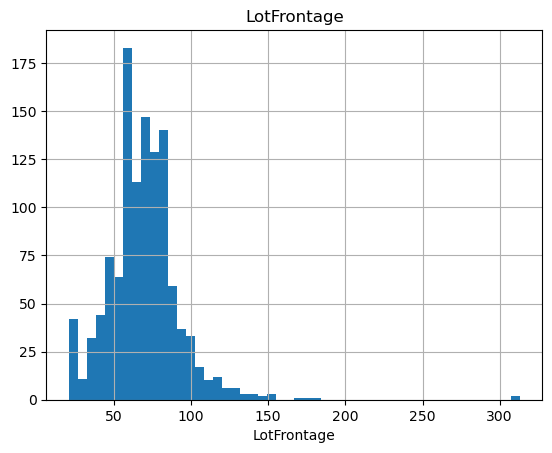

#####################################
count     1432.000
mean     10363.352
std       9917.557
min       1300.000
5%        3230.000
10%       5000.000
20%       7035.600
30%       8000.000
40%       8762.000
50%       9375.000
60%      10137.600
70%      10919.400
80%      12089.000
90%      14142.000
95%      16830.750
99%      34983.270
max     215245.000
Name: LotArea, dtype: float64


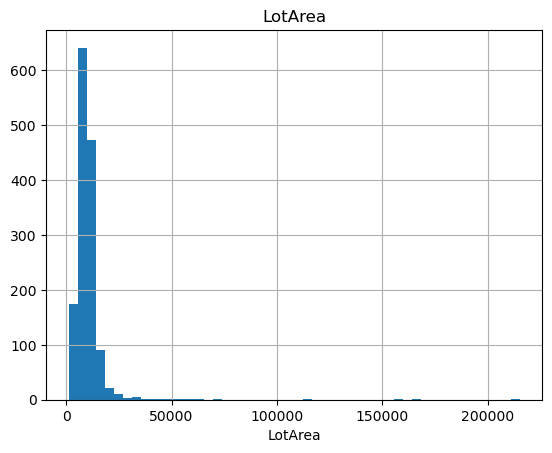

#####################################
count   1432.000
mean       6.041
std        1.325
min        1.000
5%         4.000
10%        5.000
20%        5.000
30%        5.000
40%        6.000
50%        6.000
60%        6.000
70%        7.000
80%        7.000
90%        8.000
95%        8.000
99%        9.000
max       10.000
Name: OverallQual, dtype: float64


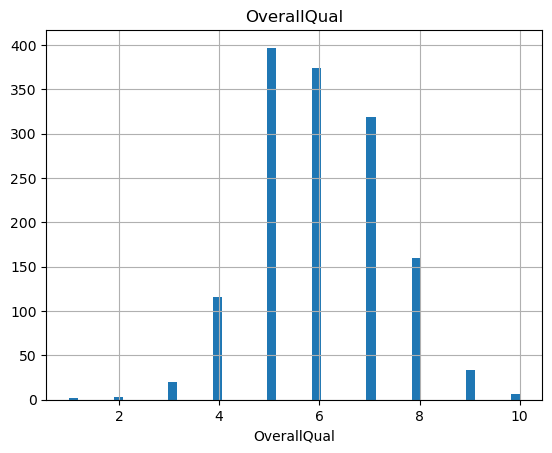

#####################################
count   1432.000
mean    1970.721
std       30.093
min     1872.000
5%      1916.000
10%     1924.000
20%     1947.000
30%     1957.000
40%     1965.000
50%     1972.000
60%     1981.000
70%     1997.000
80%     2003.000
90%     2005.900
95%     2007.000
99%     2009.000
max     2010.000
Name: YearBuilt, dtype: float64


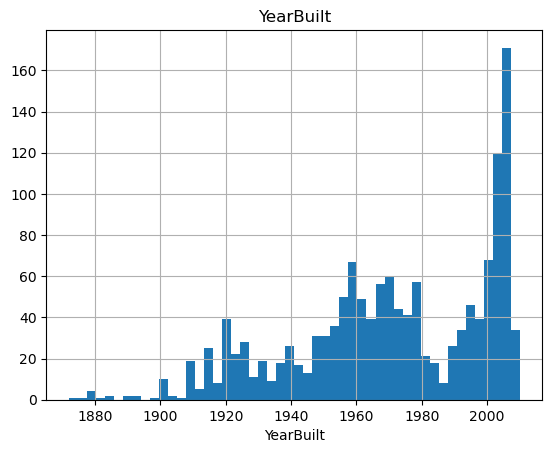

#####################################
count   1432.000
mean    1984.494
std       20.659
min     1950.000
5%      1950.000
10%     1950.000
20%     1961.000
30%     1970.000
40%     1979.000
50%     1993.000
60%     1998.000
70%     2002.000
80%     2005.000
90%     2006.000
95%     2007.000
99%     2009.000
max     2010.000
Name: YearRemodAdd, dtype: float64


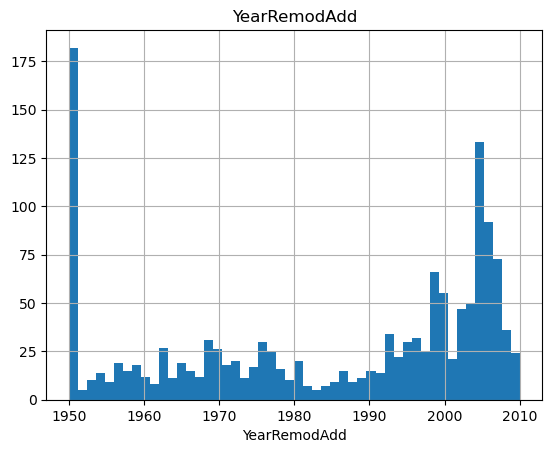

#####################################
count   1425.000
mean      96.206
std      167.329
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%      108.000
80%      194.400
90%      312.000
95%      431.200
99%      754.560
max     1600.000
Name: MasVnrArea, dtype: float64


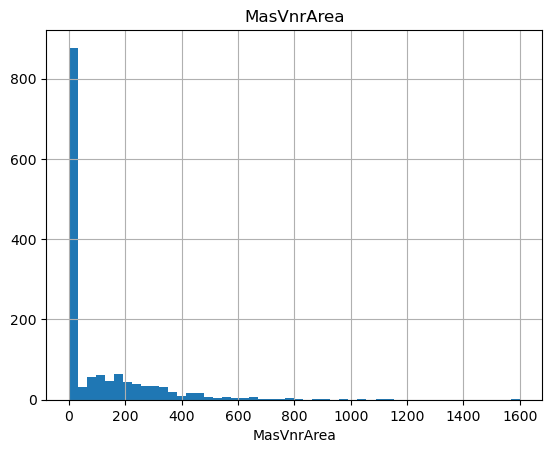

#####################################
count   1432.000
mean     430.492
std      441.542
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%      210.000
50%      377.500
60%      513.000
70%      643.700
80%      784.000
90%     1035.600
95%     1219.000
99%     1516.450
max     5644.000
Name: BsmtFinSF1, dtype: float64


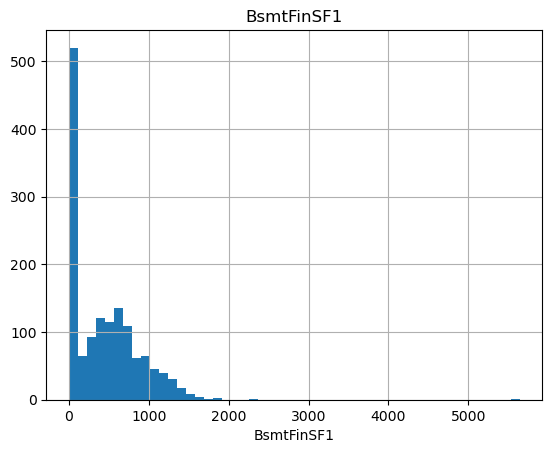

#####################################
count   1432.000
mean      46.957
std      162.209
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      118.800
95%      397.800
99%      835.420
max     1474.000
Name: BsmtFinSF2, dtype: float64


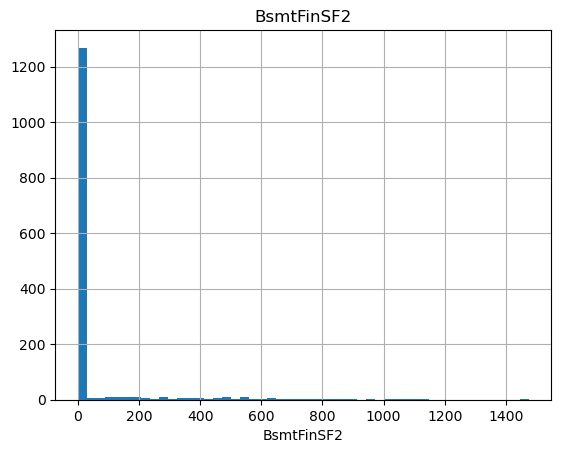

#####################################
count   1432.000
mean     562.119
std      436.354
min        0.000
5%         0.000
10%       70.200
20%      170.200
30%      278.000
40%      372.000
50%      474.000
60%      602.000
70%      732.700
80%      893.800
90%     1211.100
95%     1438.700
99%     1772.140
max     2336.000
Name: BsmtUnfSF, dtype: float64


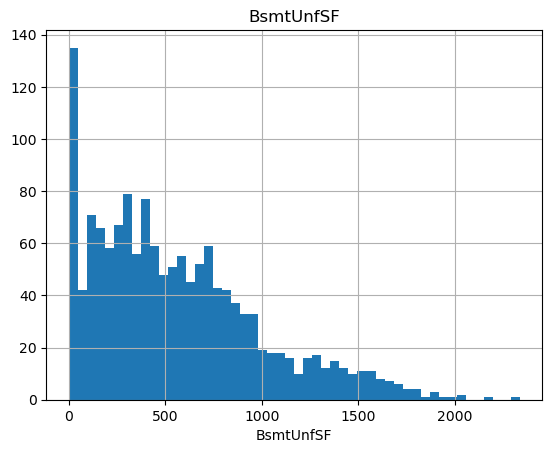

#####################################
count   1432.000
mean    1039.569
std      418.548
min        0.000
5%       505.100
10%      630.000
20%      747.000
30%      832.000
40%      897.600
50%      980.500
60%     1078.000
70%     1200.000
80%     1366.400
90%     1573.000
95%     1711.350
99%     2044.760
max     6110.000
Name: TotalBsmtSF, dtype: float64


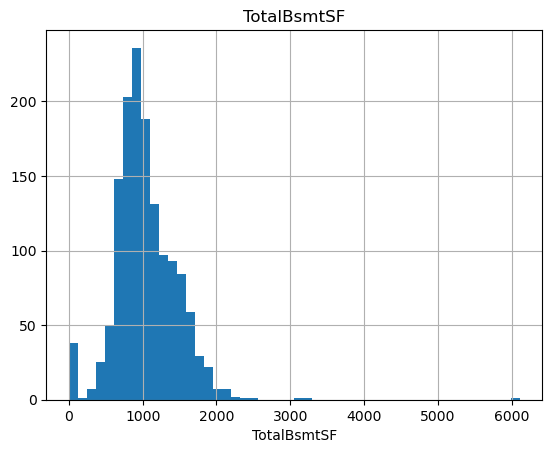

#####################################
count   1432.000
mean    1146.795
std      368.837
min      334.000
5%       672.000
10%      756.000
20%      848.000
30%      912.000
40%      992.400
50%     1078.500
60%     1166.000
70%     1298.000
80%     1458.400
90%     1652.000
95%     1777.350
99%     2125.280
max     4692.000
Name: 1stFlrSF, dtype: float64


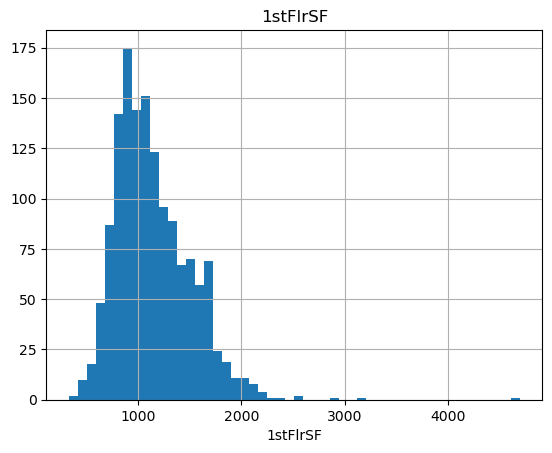

#####################################
count   1432.000
mean     338.078
std      425.401
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      440.200
70%      667.100
80%      787.800
90%      928.900
95%     1113.800
99%     1348.380
max     1818.000
Name: 2ndFlrSF, dtype: float64


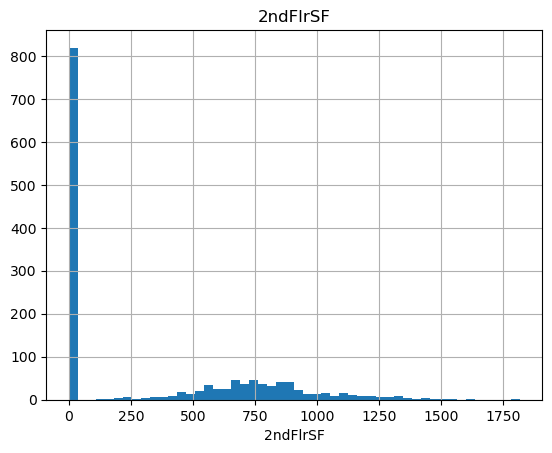

#####################################
count   1432.000
mean       5.559
std       46.752
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      320.940
max      528.000
Name: LowQualFinSF, dtype: float64


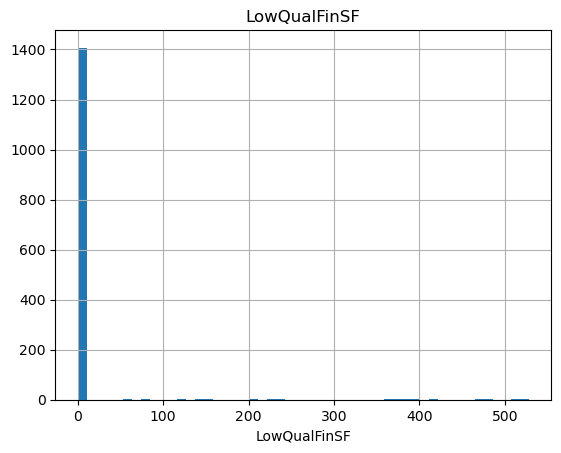

#####################################
count   1432.000
mean    1490.433
std      490.874
min      334.000
5%       848.000
10%      910.200
20%     1057.600
30%     1200.000
40%     1328.000
50%     1454.500
60%     1568.200
70%     1690.700
80%     1839.800
90%     2107.000
95%     2372.900
99%     2804.420
max     5642.000
Name: GrLivArea, dtype: float64


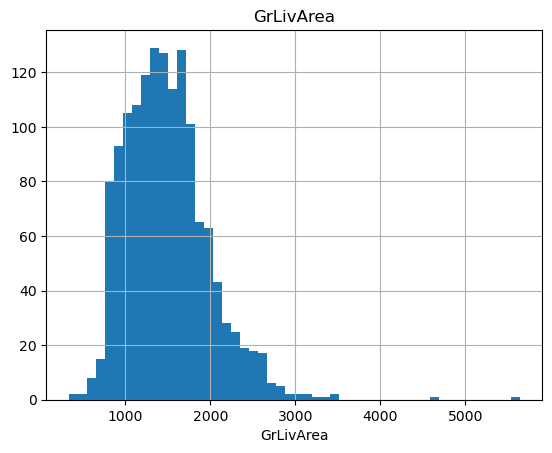

#####################################
count   1432.000
mean       6.455
std        1.566
min        2.000
5%         4.000
10%        5.000
20%        5.000
30%        6.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%        8.000
95%        9.000
99%       11.000
max       14.000
Name: TotRmsAbvGrd, dtype: float64


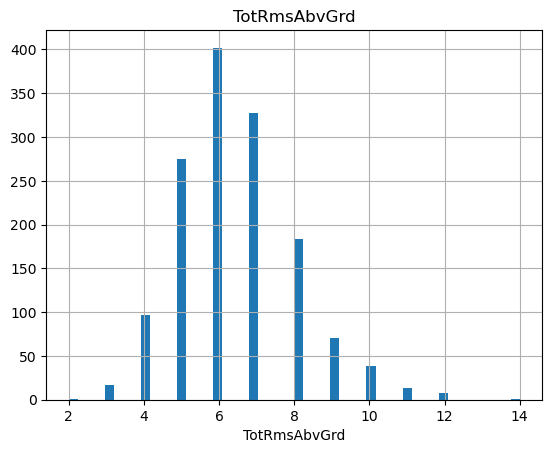

#####################################
count   1351.000
mean    1977.997
std       24.673
min     1900.000
5%      1929.500
10%     1945.000
20%     1957.000
30%     1965.000
40%     1972.000
50%     1979.000
60%     1992.000
70%     1999.000
80%     2003.000
90%     2006.000
95%     2007.000
99%     2009.000
max     2010.000
Name: GarageYrBlt, dtype: float64


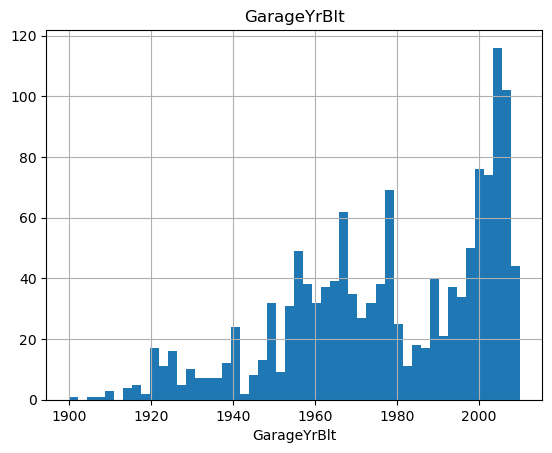

#####################################
count   1432.000
mean     466.112
std      209.215
min        0.000
5%         0.000
10%      240.000
20%      290.400
30%      380.000
40%      436.400
50%      474.000
60%      508.000
70%      550.000
80%      604.800
90%      736.000
95%      840.000
99%      963.660
max     1418.000
Name: GarageArea, dtype: float64


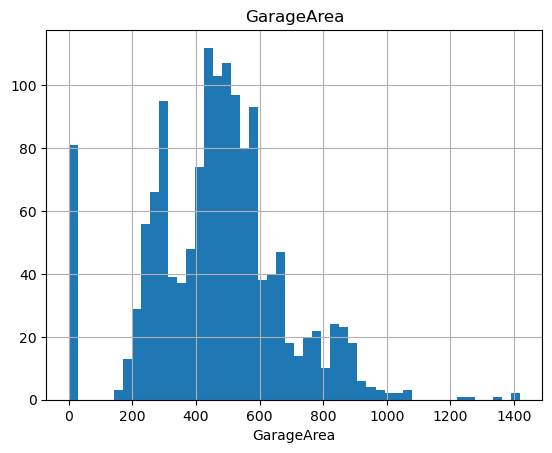

#####################################
count   1432.000
mean      92.202
std      123.915
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      100.000
70%      144.000
80%      192.000
90%      255.900
95%      326.450
99%      498.450
max      857.000
Name: WoodDeckSF, dtype: float64


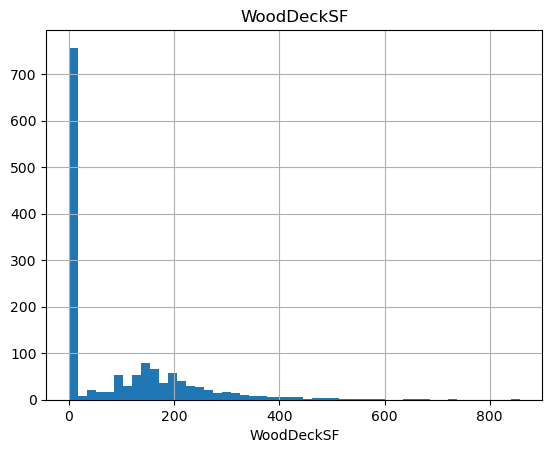

#####################################
count   1432.000
mean      45.543
std       65.568
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%       24.000
60%       39.000
70%       55.000
80%       81.000
90%      128.000
95%      172.000
99%      286.380
max      547.000
Name: OpenPorchSF, dtype: float64


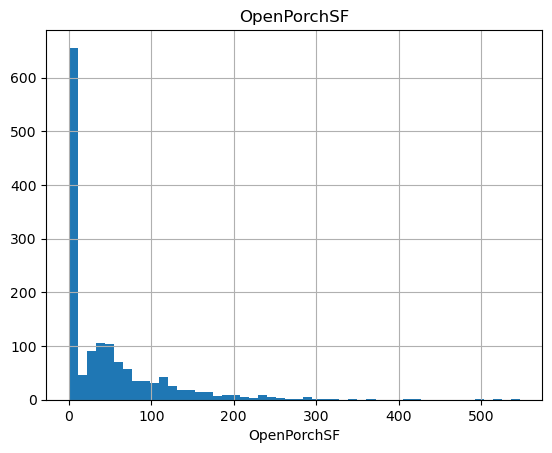

#####################################
count   1432.000
mean      22.013
std       61.048
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      112.000
95%      180.000
99%      257.450
max      552.000
Name: EnclosedPorch, dtype: float64


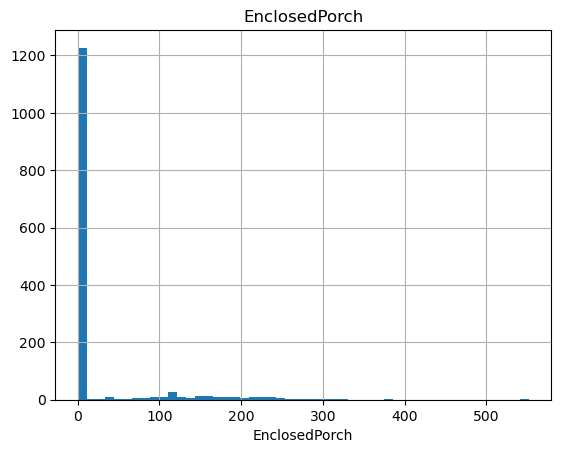

#####################################
count   1432.000
mean       3.476
std       29.599
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      168.000
max      508.000
Name: 3SsnPorch, dtype: float64


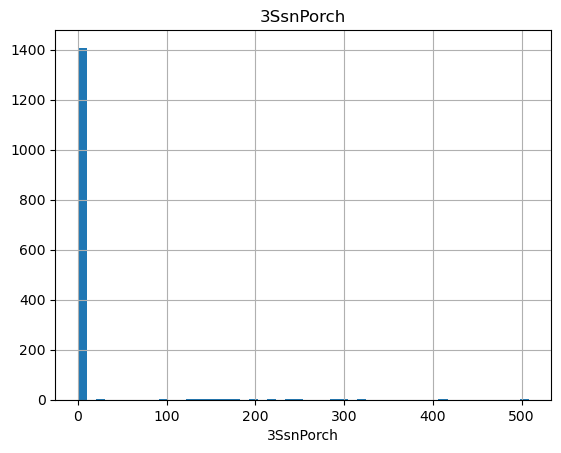

#####################################
count   1432.000
mean      14.571
std       54.593
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%      155.450
99%      265.690
max      480.000
Name: ScreenPorch, dtype: float64


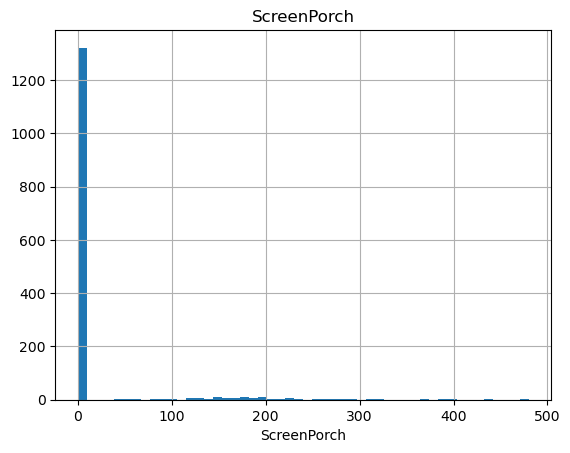

#####################################
count    1432.000
mean       44.339
std       500.916
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.000
99%       700.000
max     15500.000
Name: MiscVal, dtype: float64


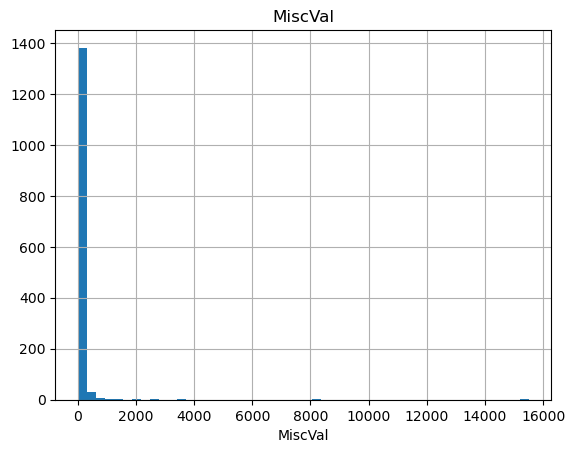

#####################################
count   1432.000
mean       6.335
std        2.704
min        1.000
5%         2.000
10%        3.000
20%        4.000
30%        5.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%       10.000
95%       11.000
99%       12.000
max       12.000
Name: MoSold, dtype: float64


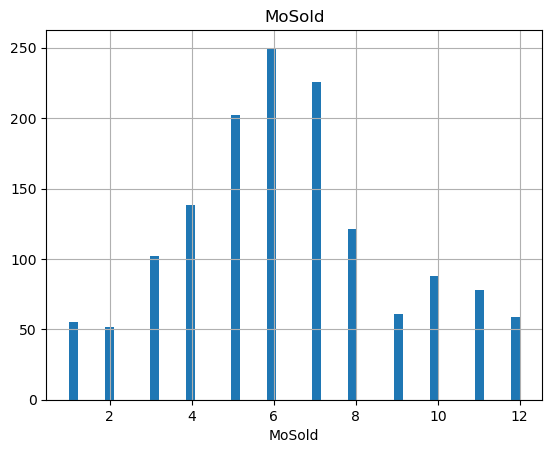

#####################################
count     1432.000
mean    174873.439
std      65922.704
min      34900.000
5%       88000.000
10%     106000.000
20%     123100.000
30%     135000.000
40%     145350.000
50%     160600.000
60%     177500.000
70%     194640.000
80%     225000.000
90%     269350.000
95%     312725.000
99%     376673.940
max     395192.000
Name: SalePrice, dtype: float64


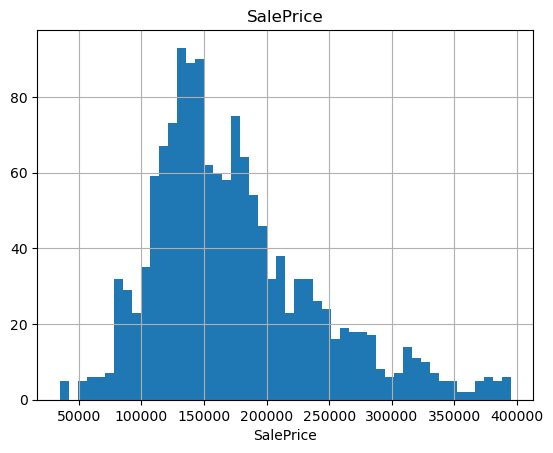

#####################################


In [6]:
######################################
# 3. Sayısal Değişken Analizi (Analysis of Numerical Variables)
######################################

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")


for col in num_cols:
    num_summary(df, col, True)

In [7]:
######################################
# 4. Hedef Değişken Analizi (Analysis of Target Variable)
######################################

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df,"SalePrice",col)

          TARGET_MEAN
MSZoning             
C (all)     74528.000
FV         214014.062
RH         131558.375
RL         183803.885
RM         124709.995


        TARGET_MEAN
Street             
Grvl     130190.500
Pave     175061.445


       TARGET_MEAN
Alley             
Grvl    122219.080
Pave    168000.585


          TARGET_MEAN
LotShape             
IR1        197376.688
IR2        203406.686
IR3        216036.500
Reg        161762.822


             TARGET_MEAN
LandContour             
Bnk           143104.079
HLS           220831.604
Low           203661.111
Lvl           173907.774


           TARGET_MEAN
Utilities             
AllPub      174899.556
NoSeWa      137500.000


           TARGET_MEAN
LotConfig             
Corner      176211.581
CulDSac     203491.000
FR2         177934.574
FR3         208475.000
Inside      171859.972


           TARGET_MEAN
LandSlope             
Gtl         173809.679
Mod         191401.859
Sev         204379.231


            TARGET_MEAN


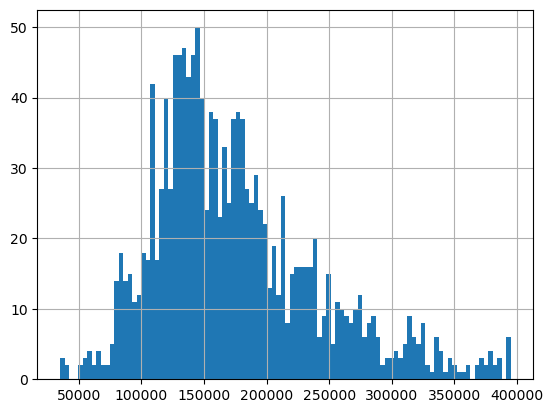

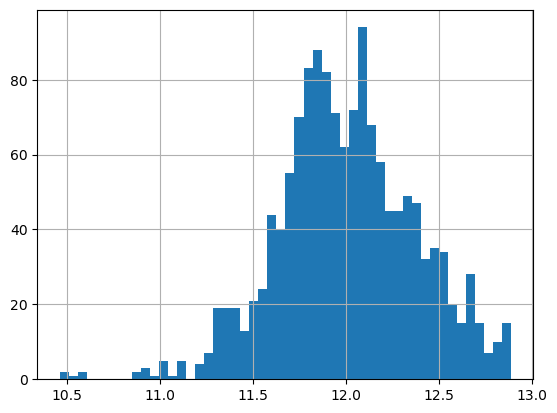

In [8]:
# Bağımlı değişkenin incelenmesi
df["SalePrice"].hist(bins=100)
plt.show()

# Bağımlı değişkenin logaritmasının incelenmesi
np.log1p(df['SalePrice']).hist(bins=50)
plt.show()

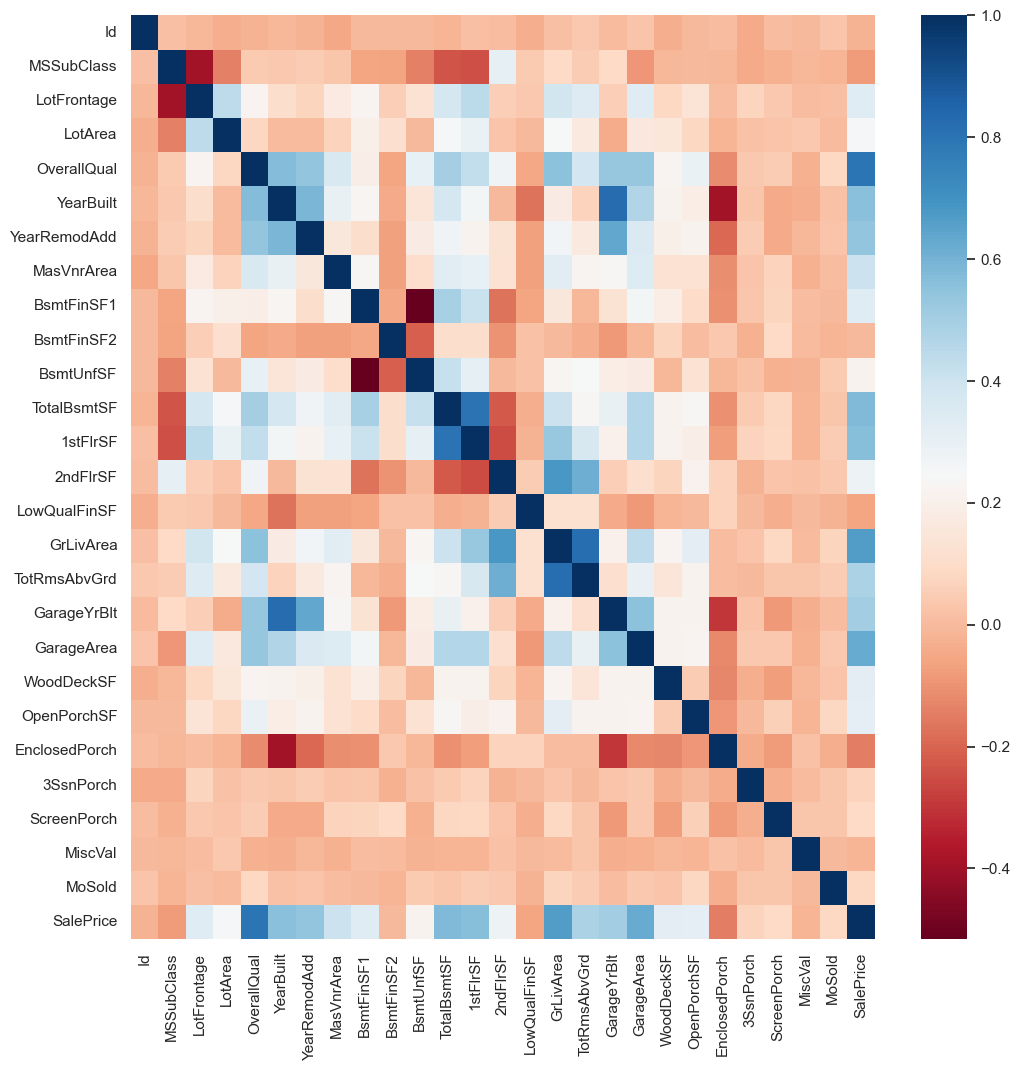

C:\Users\umut3\AppData\Local\Temp\ipykernel_26264\1689888479.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))


['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'SalePrice']

In [11]:
######################################
# 5. Korelasyon Analizi (Analysis of Correlation)
######################################

corr = df[num_cols].corr()
corr

# Korelasyonların gösterilmesi
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdBu")
plt.show()



def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

high_correlated_cols(df, plot=False)

In [12]:

######################################
# Aykırı Değer Analizi
######################################

# Aykırı değerlerin baskılanması
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in num_cols:
    if col != "SalePrice":
      print(col, check_outlier(df, col))


# Aykırı değerlerin baskılanması
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df,col)


Id False
MSSubClass False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd True
GarageYrBlt False
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
MiscVal True
MoSold False


In [13]:
######################################
# Eksik Değer Analizi
######################################


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)


df["Alley"].value_counts()
df["BsmtQual"].value_counts()


# Bazı değişkenlerdeki boş değerler evin o özelliğe sahip olmadığını ifade etmektedir
no_cols = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]

# Kolonlardaki boşlukların "No" ifadesi ile doldurulması
for col in no_cols:
    df[col].fillna("No",inplace=True)

missing_values_table(df)



# Bu fonsksiyon eksik değerlerin median veya mean ile doldurulmasını sağlar

def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data


df = quick_missing_imp(df, num_method="median", cat_length=17)


              n_miss  ratio
PoolQC          1426 99.580
MiscFeature     1378 96.230
Alley           1341 93.650
Fence           1153 80.520
FireplaceQu      690 48.180
LotFrontage      257 17.950
GarageType        81  5.660
GarageYrBlt       81  5.660
GarageFinish      81  5.660
GarageQual        81  5.660
GarageCond        81  5.660
BsmtExposure      38  2.650
BsmtFinType2      38  2.650
BsmtFinType1      37  2.580
BsmtCond          37  2.580
BsmtQual          37  2.580
MasVnrArea         7  0.490
MasVnrType         7  0.490
Electrical         1  0.070
             n_miss  ratio
LotFrontage     257 17.950
GarageYrBlt      81  5.660
MasVnrType        7  0.490
MasVnrArea        7  0.490
Electrical        1  0.070
# BEFORE
LotFrontage    257
MasVnrType       7
MasVnrArea       7
Electrical       1
GarageYrBlt     81
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

LotFrontage    0
MasVnrType     0
Mas

In [14]:
######################################
# RARE
######################################

# Kategorik kolonların dağılımının incelenmesi

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "SalePrice", cat_cols)

# Sınıfların oranlarına göre diğer sınıflara dahil edilmesi

# ExterCond : 5
#     COUNT  RATIO  TARGET_MEAN
# Ex     12  0.004   201333.333
# Fa     67  0.023   102595.143
# Gd    299  0.102   168897.568
# Po      3  0.001    76500.000
# TA   2538  0.869   184034.896



df["ExterCond"] = np.where(df.ExterCond.isin(["Fa", "Po"]), "FaPo", df["ExterCond"])
df["ExterCond"] = np.where(df.ExterCond.isin(["Ex", "Gd"]), "Ex", df["ExterCond"])




# LotShape : 4
#      COUNT  RATIO  TARGET_MEAN
# IR1    968  0.332   206101.665
# IR2     76  0.026   239833.366
# IR3     16  0.005   216036.500
# Reg   1859  0.637   164754.818

df["LotShape"] = np.where(df.LotShape.isin(["IR1", "IR2", "IR3"]), "IR", df["LotShape"])



# GarageQual : 5
#     COUNT  RATIO  TARGET_MEAN
# Ex      3  0.001   241000.000
# Fa    124  0.042   123573.354
# Gd     24  0.008   215860.714
# Po      5  0.002   100166.667
# TA   2763  0.892   187489.836

df["GarageQual"] = np.where(df.GarageQual.isin(["Fa", "Po"]), "FaPo", df["GarageQual"])
df["GarageQual"] = np.where(df.GarageQual.isin(["Ex", "Gd", "TA"]), "ExGd", df["GarageQual"])


# BsmtFinType2 : 6
#      COUNT  RATIO  TARGET_MEAN
# ALQ     52  0.018   209942.105
# BLQ     68  0.023   151101.000
# GLQ     34  0.012   180982.143
# LwQ     87  0.030   164364.130
# Rec    105  0.036   164917.130
# Unf   2493  0.854   184694.690

df["BsmtFinType2"] = np.where(df.BsmtFinType2.isin(["GLQ", "ALQ"]), "RareExcellent", df["BsmtFinType2"])
df["BsmtFinType2"] = np.where(df.BsmtFinType2.isin(["BLQ", "LwQ", "Rec"]), "RareGood", df["BsmtFinType2"])


# Nadir sınıfların tespit edilmesi
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df


rare_encoder(df,0.01)


MSZoning : 5
         COUNT  RATIO  TARGET_MEAN
C (all)     10  0.007    74528.000
FV          65  0.045   214014.062
RH          16  0.011   131558.375
RL        1124  0.785   183803.885
RM         217  0.152   124709.995


Street : 2
      COUNT  RATIO  TARGET_MEAN
Grvl      6  0.004   130190.500
Pave   1426  0.996   175061.445


Alley : 3
      COUNT  RATIO  TARGET_MEAN
Grvl     50  0.035   122219.080
No     1341  0.936   177046.820
Pave     41  0.029   168000.585


LotShape : 4
     COUNT  RATIO  TARGET_MEAN
IR1    471  0.329   197376.688
IR2     35  0.024   203406.686
IR3     10  0.007   216036.500
Reg    916  0.640   161762.822


LandContour : 4
     COUNT  RATIO  TARGET_MEAN
Bnk     63  0.044   143104.079
HLS     48  0.034   220831.604
Low     36  0.025   203661.111
Lvl   1285  0.897   173907.774


Utilities : 2
        COUNT  RATIO  TARGET_MEAN
AllPub   1431  0.999   174899.556
NoSeWa      1  0.001   137500.000


LotConfig : 5
         COUNT  RATIO  TARGET_MEAN
Corner     260  

Id  MSSubClass MSZoning  LotFrontage   LotArea Street Alley  \
0       1.000          60       RL       65.000  8450.000   Pave    No   
1       2.000          20       RL       80.000  9600.000   Pave    No   
2       3.000          60       RL       68.000 11250.000   Pave    No   
3       4.000          70       RL       60.000  9550.000   Pave    No   
4       5.000          60       RL       84.000 14260.000   Pave    No   
5       6.000          50       RL       85.000 14115.000   Pave    No   
6       7.000          20       RL       75.000 10084.000   Pave    No   
7       8.000          60       RL       69.000 10382.000   Pave    No   
8       9.000          50       RM       51.000  6120.000   Pave    No   
9      10.000         190       RL       50.000  7420.000   Pave    No   
10     11.000          20       RL       70.000 11200.000   Pave    No   
11     12.000          60       RL       85.000 11924.000   Pave    No   
12     13.000          20       RL       69.000 12968.000   Pave    No   
13     14.000          20       RL       91.000 10652.000   Pave    No   
14     15.000          20       RL       69.000 10920.000   Pave    No   
15     16.000          45       RM       51.000  6120.000   Pave    No   
16     17.000          20       RL       69.000 11241.000   Pave    No   
17     18.000          90       RL       72.000 10791.000   Pave    No   
18     19.000          20       RL       66.000 13695.000   Pave    No   
19     20.000          20       RL       70.000  7560.000   Pave    No   
20     21.000          60       RL      101.000 14215.000   Pave    No   
21     22.000          45       RM       57.000  7449.000   Pave  Grvl   
22     23.000          20       RL       75.000  9742.000   Pave    No   
23     24.000         120       RM       44.000  4224.000   Pave    No   
24     25.000          20       RL       69.000  8246.000   Pave    No   
25     26.000          20       RL      110.000 14230.000   Pave    No   
26     27.000          20       RL       60.000  7200.000   Pave    No   
27     28.000          20       RL       98.000 11478.000   Pave    No   
28     29.000          20       RL       47.000 16321.000   Pave    No   
29     30.000          30       RM       60.000  6324.000   Pave    No   
30     31.000          70     Rare       50.000  8500.000   Pave  Pave   
31     32.000          20       RL       69.000  8544.000   Pave    No   
32     33.000          20       RL       85.000 11049.000   Pave    No   
33     34.000          20       RL       70.000 10552.000   Pave    No   
34     35.000         120       RL       60.000  7313.000   Pave    No   
35     36.000          60       RL      108.000 13418.000   Pave    No   
36     37.000          20       RL      112.000 10859.000   Pave    No   
37     38.000          20       RL       74.000  8532.000   Pave    No   
38     39.000          20       RL       68.000  7922.000   Pave    No   
39     40.000          90       RL       65.000  6040.000   Pave    No   
40     41.000          20       RL       84.000  8658.000   Pave    No   
41     42.000          20       RL      115.000 16905.000   Pave    No   
42     43.000          85       RL       69.000  9180.000   Pave    No   
43     44.000          20       RL       69.000  9200.000   Pave    No   
44     45.000          20       RL       70.000  7945.000   Pave    No   
45     46.000         120       RL       61.000  7658.000   Pave    No   
46     47.000          50       RL       48.000 12822.000   Pave    No   
47     48.000          20       FV       84.000 11096.000   Pave    No   
48     49.000         190       RM       33.000  4456.000   Pave    No   
49     50.000          20       RL       66.000  7742.000   Pave    No   
50     51.000          60       RL       69.000 13869.000   Pave    No   
51     52.000          50       RM       52.000  6240.000   Pave    No   
52     53.000          90       RM      110.000  8472.000   Rare    No   
53     54.000  

In [15]:
######################################
# GÖREV 3 : Yeni değişkenler oluşturunuz ve oluşturduğunuz yeni değişkenlerin başına 'NEW' ekleyiniz.
######################################

df["NEW_1st*GrLiv"] = (df["1stFlrSF"]*df["GrLivArea"])

df["NEW_Garage*GrLiv"] = (df["GarageArea"]*df["GrLivArea"])

df["TotalQual"] = df[["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtCond", "BsmtFinType1",
                      "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageQual", "GarageCond", "Fence"]].sum(axis = 1)

df["TotalGarageQual"] = df[["GarageQual", "GarageCond"]].sum(axis = 1)

df["Overall"] = df[["OverallQual", "OverallCond"]].sum(axis = 1)

df["Exter"] = df[["ExterQual", "ExterCond"]].sum(axis = 1)

df["Qual"] = df[["OverallQual", "ExterQual", "GarageQual", "Fence", "BsmtFinType1", "BsmtFinType2", "KitchenQual", "FireplaceQu"]].sum(axis = 1)

df["Cond"] = df[["OverallCond", "ExterCond", "GarageCond", "BsmtCond", "HeatingQC", "Functional"]].sum(axis = 1)

# Total Floor
df["NEW_TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"]

# Total Finished Basement Area
df["NEW_TotalBsmtFin"] = df.BsmtFinSF1 + df.BsmtFinSF2

# Porch Area
df["NEW_PorchArea"] = df.OpenPorchSF + df.EnclosedPorch + df.ScreenPorch + df["3SsnPorch"] + df.WoodDeckSF

# Total House Area
df["NEW_TotalHouseArea"] = df.NEW_TotalFlrSF + df.TotalBsmtSF

df["NEW_TotalSqFeet"] = df.GrLivArea + df.TotalBsmtSF

df["NEW_TotalFullBath"] = df.BsmtFullBath + df.FullBath
df["NEW_TotalHalfBath"] = df.BsmtHalfBath + df.HalfBath

df["NEW_TotalBath"] = df["NEW_TotalFullBath"] + (df["NEW_TotalHalfBath"]*0.5)

# Lot Ratio
df["NEW_LotRatio"] = df.GrLivArea / df.LotArea

df["NEW_RatioArea"] = df.NEW_TotalHouseArea / df.LotArea

df["NEW_GarageLotRatio"] = df.GarageArea / df.LotArea

# MasVnrArea
df["NEW_MasVnrRatio"] = df.MasVnrArea / df.NEW_TotalHouseArea

# Dif Area
df["NEW_DifArea"] = (df.LotArea - df["1stFlrSF"] - df.GarageArea - df.NEW_PorchArea - df.WoodDeckSF)

# LowQualFinSF
df["NEW_LowQualFinSFRatio"] = df.LowQualFinSF / df.NEW_TotalHouseArea

df["NEW_OverallGrade"] = df["OverallQual"] * df["OverallCond"]

# Overall kitchen score
df["NEW_KitchenScore"] = df["KitchenAbvGr"] * df["KitchenQual"]
# Overall fireplace score
df["NEW_FireplaceScore"] = df["Fireplaces"] * df["FireplaceQu"]


df["NEW_Restoration"] = df.YearRemodAdd - df.YearBuilt

df["NEW_HouseAge"] = df.YrSold - df.YearBuilt

df["NEW_RestorationAge"] = df.YrSold - df.YearRemodAdd

df["NEW_GarageAge"] = df.GarageYrBlt - df.YearBuilt

df["NEW_GarageRestorationAge"] = np.abs(df.GarageYrBlt - df.YearRemodAdd)

df["NEW_GarageSold"] = df.YrSold - df.GarageYrBlt



drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]

# drop_list'teki değişkenlerin düşürülmesi
df.drop(drop_list, axis=1, inplace=True)

In [16]:
##################
# GÖREV 4 : Label Encoding & One-Hot Encoding işlemlerinin uygulanması
##################

cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and len(df[col].unique()) == 2]

for col in binary_cols:
    label_encoder(df, col)


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

Observations: 1432
Variables: 103
cat_cols: 57
num_cols: 46
cat_but_car: 0
num_but_cat: 19


In [17]:
##################################
# MODELLEME
##################################

##################################
# GÖREV 5: Modeli kurma işlemini gerçekleştiriniz.
##################################

# Log dönüşümünün gerçekleştirilmesi
y = np.log1p(df['SalePrice'])
X = df.drop(["Id", "SalePrice"], axis=1)

# Verinin eğitim ve tet verisi olarak bölünmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          #('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]
          # ("CatBoost", CatBoostRegressor(verbose=False))]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")



df['SalePrice'].mean()
df['SalePrice'].std()

RMSE: 354.283 (LR) 
RMSE: 0.1279 (Ridge) 
RMSE: 0.1732 (Lasso) 
RMSE: 0.1525 (ElasticNet) 
RMSE: 0.2301 (KNN) 
RMSE: 0.1986 (CART) 
RMSE: 0.1337 (RF) 
RMSE: 0.1255 (GBM) 
RMSE: 0.1384 (XGBoost) 
RMSE: 0.1303 (LightGBM) 


65922.70393689284

In [ ]:
##################
# GÖREV 6 : Görev 5'deki sonuçlara dayanarak hiperparametre optimizasyonlarını gerçekleştiriniz.
##################


lgbm_model = LGBMRegressor(random_state=46)

rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model, X, y, cv=5, scoring="neg_mean_squared_error")))


lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1500]
               #"colsample_bytree": [0.5, 0.7, 1]
             }

lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)

# normal y cv süresi: 16.2s
# scale edilmiş y ile: 13.8s

final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))


##################
# GÖREV 7 : Modelin test ediniz ve 22222'nin altına düşmeye çalışınız.
##################
lgbm_tuned = LGBMRegressor(**lgbm_gs_best.best_params_).fit(X_train, y_train)
y_pred = lgbm_tuned.predict(X_test)


# Yapılan LOG dönüşümünün tersinin (inverse'nin) alınması
new_y = np.expm1(y_pred)
new_y_test = np.expm1(y_test)

np.sqrt(mean_squared_error(new_y_test, new_y))

# RMSE : 22118.413146021652

Fitting 3 folds for each of 4 candidates, totalling 12 fits
